In [14]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.interpolate import splprep, splev
import open3d as o3d
from skimage import measure

def fill_gaps(points):
    filled_points = []
    for i in range(points.shape[1] - 1):
        start = points[:, i]
        end = points[:, i + 1]
        filled_points.append(start)
        while not np.array_equal(start, end):
            if start[0] < end[0]:
                start[0] += 1
            elif start[0] > end[0]:
                start[0] -= 1
            if start[1] < end[1]:
                start[1] += 1
            elif start[1] > end[1]:
                start[1] -= 1
            filled_points.append(start.copy())
    filled_points.append(points[:, -1])
    return np.array(filled_points).T


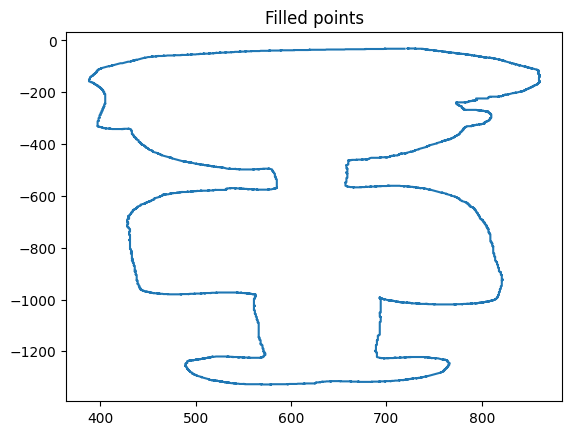

In [29]:
new_points_int = np.loadtxt("points.txt", delimiter=',').astype(int).T
filled_points = fill_gaps(new_points_int)
rot = np.array([[0, 1], [-1, 0]])
flopped_points = rot @ filled_points
plt.plot(flopped_points[0], flopped_points[1]); plt.title("Filled points"); plt.show()


In [33]:
# Define the user-specified depth value
depth_value = 50  # You can change this value as needed

# Duplicate the points to replicate depth
# Create the depth points using np.tile
depth_points = np.vstack((
    np.tile(filled_points[0], depth_value),
    np.tile(filled_points[1], depth_value),
    np.repeat(np.arange(depth_value), len(filled_points[0]))
))

threed_points = np.column_stack(depth_points)

In [34]:
# Create a point cloud from the depth points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(threed_points.astype(float))
#o3d.visualization.draw_geometries([pcd])

In [35]:
# Create a voxel grid
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=1)
#o3d.visualization.draw_geometries([voxel_grid])

In [36]:
voxel_indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()])
voxel_array = np.zeros((voxel_indices.max(0) + 1), dtype=bool)
voxel_array[tuple(voxel_indices.T)] = True
# Use the marching cubes algorithm to obtain the mesh
verts, faces, normals, values = measure.marching_cubes(voxel_array, level=0)

In [37]:
verts = verts.astype("float64")
faces = faces.astype("int32")
normals = normals.astype("float64")

In [38]:
# Create a mesh from the vertices and faces
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.vertex_normals = o3d.utility.Vector3dVector(normals)

In [39]:
o3d.visualization.draw_geometries([mesh])